# Learning PyTorch

## Prepare Data

In [1]:
%matplotlib inline
from random import choice, randrange
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import random

EOS = "<EOS>" #all strings will end with the End Of String token
PAD = "<PAD>"
characters = list("abcd")
characters.append(EOS)
characters.append(PAD)

int2char = list(characters)
char2int = {c:i for i,c in enumerate(characters)}

VOCAB_SIZE = len(characters)
PAD_IDX = VOCAB_SIZE - 1

def sample_model(min_length, max_lenth):
    random_length = randrange(min_length, max_lenth)                             # Pick a random length
    random_char_list = [choice(characters[:-2]) for _ in range(random_length)]  # Pick random chars
    random_string = ''.join(random_char_list) 
    return random_string, random_string[::-1]  # Return the random string and its reverse
    

MIN_STRING_LEN = 1
MAX_STRING_LEN = 10
TRAIN_SET_SIZE = 5000
VAL_SET_SIZE = 10

batch_size = 100

RNN_NUM_OF_LAYERS = 1
EMBEDDINGS_SIZE = 4
STATE_SIZE = 64

default_epochs = 50

use_gpu = False

train_set = [sample_model(MIN_STRING_LEN, MAX_STRING_LEN) for _ in range(TRAIN_SET_SIZE)]
val_set = [sample_model(MIN_STRING_LEN, MAX_STRING_LEN) for _ in range(VAL_SET_SIZE)]

## PyTorch

### Helpers

In [2]:
def _preprocess_string(strings):
    batch_size = len(strings)

    strings_with_eos = [list(string) + [EOS] for string in strings]
    max_len = max([len(string) for string in strings_with_eos])
    padded_strings = [string + [PAD] * (max_len - len(string)) for string in strings_with_eos]
    len_first = [[padded_strings[j][i]for j in range(batch_size)] for i in range(max_len)]
    int_strings = [[char2int[c] for c in string] for string in len_first]
    var = Variable(torch.LongTensor(int_strings))
    if use_gpu: return var.cuda()
    return var

def get_loss(network, input_strings, output_strings):
    batch_size = len(output_strings)
    input_strings = _preprocess_string(input_strings)
    output_strings = _preprocess_string(output_strings)

    probs = network(input_strings, batch_size)
    
    loss = sum([F.cross_entropy(p, t, ignore_index=PAD_IDX) for p, t in zip(probs, output_strings)])
    return loss

def generate(network, input_string):
    input_string = _preprocess_string([input_string])
    probs = network(input_string, 1)
    generated = [int2char[prob[0].topk(1)[1][0]] for prob in probs.data]
    return (''.join(generated)).split(EOS)[0].replace(PAD, '')

def batcher(dataset, epochs = 1):
    sources, targets = [], []
    i = 0
    for _ in range(epochs):
        for source, target in dataset:
            i+=1
            sources.append(source), targets.append(target)
            if len(sources) >= batch_size:
                yield sources, targets
                sources, targets = [], []
    if sources: yield sources, targets

In [3]:
def train(network, train_set, val_set, epochs=default_epochs):
    def get_val_set_loss(network, val_set):
        losses = [get_loss(network, input_strings, output_strings).data[0]
                 for input_strings, output_strings in batcher(val_set)]
        return sum(losses)
    if use_gpu: network.cuda()
    losses = []
    iterations = []
    optim = torch.optim.Adam(network.parameters())
    
    total_iterations = max(int((len(train_set)*epochs)/batch_size), 100)
    for i, (input_strings, output_strings) in enumerate(tqdm(batcher(train_set, epochs=epochs))):
              
        optim.zero_grad()
        loss = get_loss(network, input_strings, output_strings)
        loss.backward()
        optim.step()
            
        # Accumulate average losses over training to plot
        if i%int(total_iterations/100) == 0:
            val_loss = get_val_set_loss(network, val_set)
            losses.append(val_loss)
            iterations.append(i/((len(train_set)/100)))

    plt.plot(iterations, losses)
    #plt.axis([0, 100, 0, 100])
    plt.show() 
    print('loss on validation set:', val_loss)

### LSTM

In [4]:
class SimpleRNNNetwork(nn.Module):
    def __init__(self,num_of_layers, embeddings_size, state_size):
        super(SimpleRNNNetwork, self).__init__()
        self.num_of_layers = num_of_layers
        self.state_size = state_size
        
        # the embedding paramaters
        self.embeddings = nn.Embedding(VOCAB_SIZE, embeddings_size, padding_idx=PAD_IDX)

        # the rnn
        self.RNN = nn.LSTM(embeddings_size, state_size, num_of_layers)
        
        # project the rnn output to a vector of VOCAB_SIZE length
        self.linear = nn.Linear(state_size, VOCAB_SIZE)    
        
    def lstm_init_func(self, batch_size):
        h0 = Variable(torch.zeros(self.num_of_layers, batch_size, self.state_size))
        c0 = Variable(torch.zeros(self.num_of_layers, batch_size, self.state_size))
        if use_gpu: return h0.cuda(), c0.cuda()
        return h0,c0
    
    def forward(self, input_string, batch_size):                        
        embedded = self.embeddings(input_string)
        output, hn = self.RNN(embedded, self.lstm_init_func(batch_size))
        output = output
        logits = self.linear(output)
        return logits #F.log_softmax(logits, 2)   

2500it [00:52, 47.61it/s]


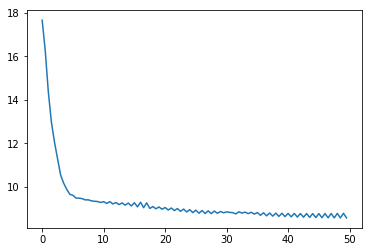

loss on validation set: 8.562350273132324
abb


In [5]:
lstm_net = SimpleRNNNetwork(RNN_NUM_OF_LAYERS, EMBEDDINGS_SIZE, STATE_SIZE)
train(lstm_net, train_set, val_set)
print(generate(lstm_net, 'abc'))

### encoder-decoder

In [6]:
class EncoderDecoderNetwork(nn.Module):
    def __init__(self, num_of_layers, embeddings_size, state_size):
        super(EncoderDecoderNetwork, self).__init__()
        self.num_of_layers = num_of_layers
        self.state_size = state_size
        
        self.embeddings = nn.Embedding(VOCAB_SIZE, embeddings_size, padding_idx=PAD_IDX)

        self.enc = nn.LSTM(embeddings_size, state_size, num_of_layers)
        self.dec = nn.LSTM(state_size, state_size, num_of_layers)
        
        self.linear = nn.Linear(state_size, VOCAB_SIZE)
    
    def get_rnn_init_state(self, batch_size):
        h0 = Variable(torch.zeros(self.num_of_layers, batch_size, self.state_size))
        c0 = Variable(torch.zeros(self.num_of_layers, batch_size, self.state_size))
        if use_gpu: return h0.cuda(), c0.cuda()
        return h0, c0
    
    def encode(self, encoder_outputs, decoder_state):
        return encoder_outputs[-1].unsqueeze(0)
    
    def forward(self, input_string, batch_size):
        embedded = self.embeddings(input_string)
        encoder_outputs, hn = self.enc(embedded, self.get_rnn_init_state(batch_size))
        
        hidden = self.get_rnn_init_state(batch_size)
        
        outputs = []
        for _ in range(len(input_string)):
            encoded = self.encode(encoder_outputs, hidden[0])
            output, hidden = self.dec(encoded, hidden)
            outputs.append(output)
        logits = self.linear(torch.cat(outputs, 0))

        return logits #F.log_softmax(logits, 2)

2500it [01:46, 23.43it/s]


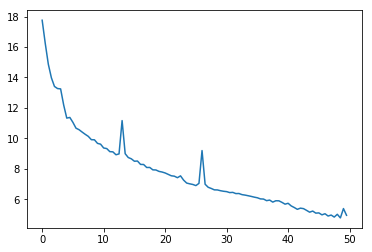

loss on validation set: 4.955488681793213
bbbbb
ccccccaab


In [7]:
encoder_decoder = EncoderDecoderNetwork(RNN_NUM_OF_LAYERS, EMBEDDINGS_SIZE, STATE_SIZE)
train(encoder_decoder, train_set, val_set)
print(generate(encoder_decoder, 'abcd'))
print(generate(encoder_decoder, 'abcdabcdabcdabcd'))

### Attention

In [8]:
class EncoderDecoderAttentionNetwork(EncoderDecoderNetwork):
    def __init__(self, num_of_layers, embeddings_size, state_size):
        super(EncoderDecoderAttentionNetwork, self).__init__(num_of_layers, embeddings_size, state_size)
        # the attention
        self.att_w1 = nn.Linear(state_size, state_size, bias=False)
        self.att_w2 = nn.Linear(state_size, state_size)
        self.att_v = nn.Linear(state_size, 1)

    def encode(self, encoder_outputs, decoder_state):
        decoder_state = decoder_state[-1].unsqueeze(0) # Use only the last layer
        unnormalized_att = self.att_v(F.tanh(self.att_w1(decoder_state) + self.att_w2(encoder_outputs)))
        att = F.softmax(unnormalized_att.permute(1,0,2), dim=1).permute(1,0,2)
        attended = encoder_outputs.mul(att).sum(0)
        return attended.unsqueeze(0)

2500it [03:29, 11.91it/s]


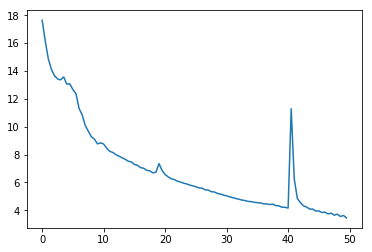

loss on validation set: 3.4557623863220215
ccccccccba


In [9]:
att = EncoderDecoderAttentionNetwork(RNN_NUM_OF_LAYERS, EMBEDDINGS_SIZE, STATE_SIZE)
train(att, train_set, val_set)
print(generate(att, 'abcdabcdabcdabcd'))

### Print Attention

In [10]:
class AttentionNetworkWithPrint(EncoderDecoderAttentionNetwork):
    def __init__(self, num_of_layers, embeddings_size, state_size):
        super(AttentionNetworkWithPrint, self).__init__(num_of_layers, embeddings_size, state_size)

        self.should_print = False
        self.att_mat = []
    
    def encode(self, encoder_outputs, decoder_state):
        unnormalized_att = self.att_v(F.tanh(self.att_w1(decoder_state) + self.att_w2(encoder_outputs)))
        att = F.softmax(unnormalized_att.permute(1,0,2), dim=1).permute(1,0,2)
        if self.should_print:
            self.att_mat.append(att.data.numpy())
        attended = encoder_outputs.mul(att).sum(0)
        return attended.unsqueeze(0)
    
    def _plot_attention(self, matrix, max_weight=None, ax=None):
        """Draw Hinton diagram for visualizing a weight matrix."""
        ax = ax if ax is not None else plt.gca()

        if not max_weight:
            max_weight = 2**np.ceil(np.log(np.abs(matrix).max())/np.log(2))

        ax.patch.set_facecolor('gray')
        ax.set_aspect('equal', 'box')
        ax.xaxis.set_major_locator(plt.NullLocator())
        ax.yaxis.set_major_locator(plt.NullLocator())

        for (x, y, _, _), w in np.ndenumerate(matrix):
            color = 'white' if w > 0 else 'black'
            size = np.sqrt(np.abs(w))
            rect = plt.Rectangle([x - size / 2, y - size / 2], size, size,
                                 facecolor=color, edgecolor=color)
            ax.add_patch(rect)

        ax.autoscale_view()
        ax.invert_yaxis()
        plt.show()
    
    def generate_and_plot_attention(self, input_string):
        self.should_print = True
        self.att_mat = []
        output_string = generate(self, input_string)

        self._plot_attention(np.array(self.att_mat))
        att.should_print = False
        att.att_mat = []
        return output_string

2500it [03:31, 11.83it/s]


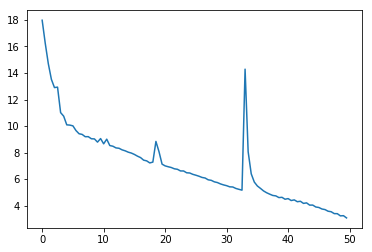

loss on validation set: 3.070519208908081


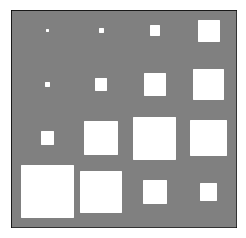

caba


In [11]:
att = AttentionNetworkWithPrint(RNN_NUM_OF_LAYERS, EMBEDDINGS_SIZE, STATE_SIZE)
train(att, train_set, val_set)
print(att.generate_and_plot_attention('abc'))

50it [00:04, 10.49it/s]


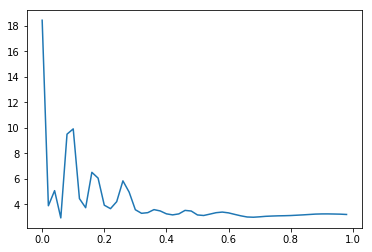

loss on validation set: 3.217738389968872


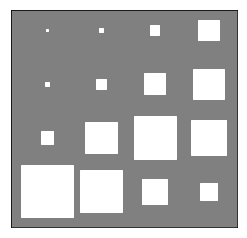

0it [00:00, ?it/s]

ccaa


50it [00:04, 12.28it/s]


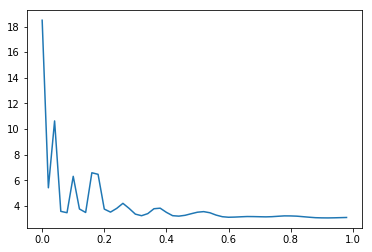

loss on validation set: 3.1001389026641846


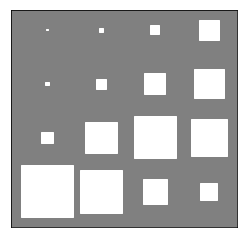

0it [00:00, ?it/s]

ccaa


50it [00:04, 11.15it/s]


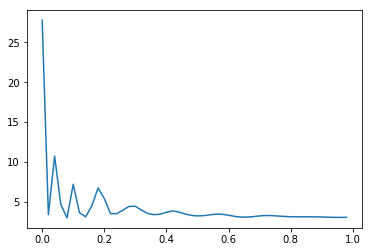

loss on validation set: 3.0672597885131836


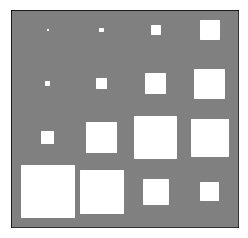

0it [00:00, ?it/s]

ccaa


50it [00:04, 11.49it/s]


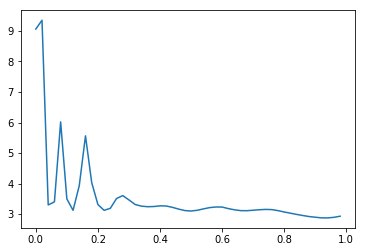

loss on validation set: 2.931352376937866


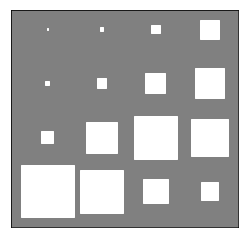

0it [00:00, ?it/s]

ccaa


50it [00:03, 12.51it/s]


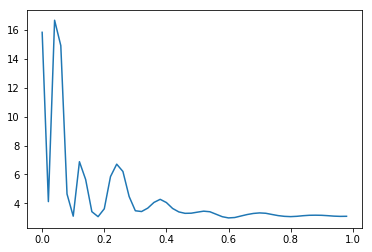

loss on validation set: 3.0963034629821777


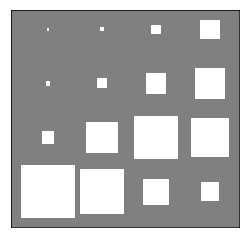

0it [00:00, ?it/s]

ccab


50it [00:03, 12.64it/s]


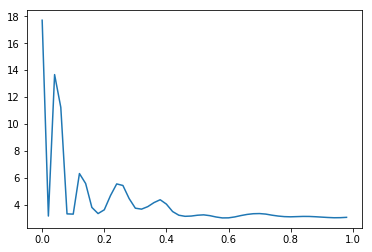

loss on validation set: 3.0550808906555176


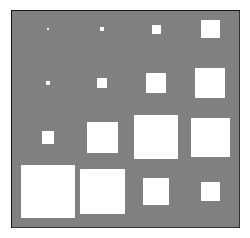

0it [00:00, ?it/s]

ccab


50it [00:04, 11.65it/s]


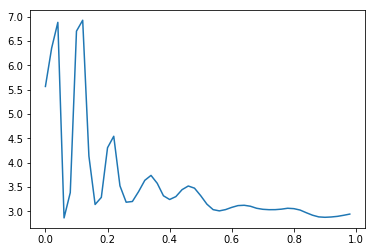

loss on validation set: 2.9435200691223145


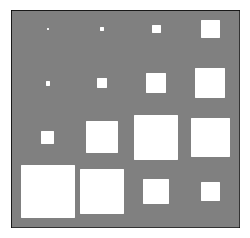

0it [00:00, ?it/s]

ccab


50it [00:04, 10.65it/s]


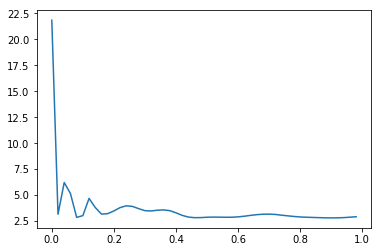

loss on validation set: 2.9179413318634033


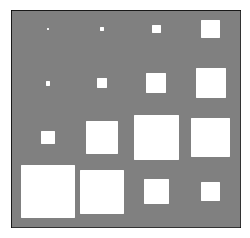

0it [00:00, ?it/s]

ccab


50it [00:03, 12.55it/s]


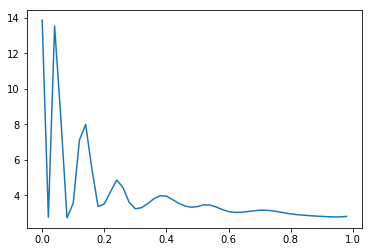

loss on validation set: 2.8224241733551025


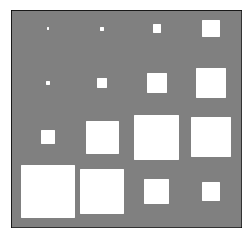

0it [00:00, ?it/s]

ccab


50it [00:03, 12.57it/s]


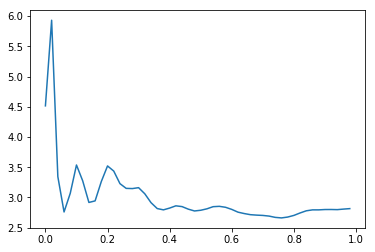

loss on validation set: 2.8159666061401367


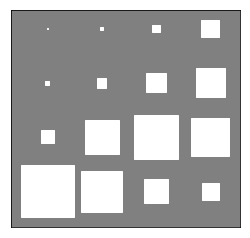

0it [00:00, ?it/s]

ccab


50it [00:04, 11.91it/s]


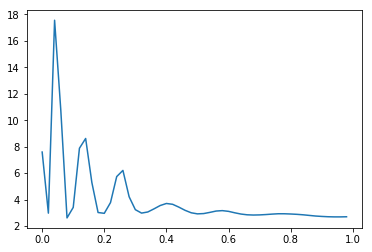

loss on validation set: 2.6942849159240723


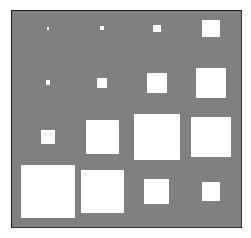

0it [00:00, ?it/s]

ccab


50it [00:04, 11.67it/s]


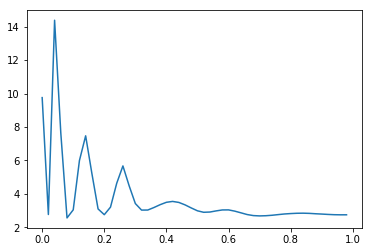

loss on validation set: 2.7494451999664307


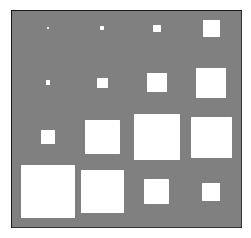

0it [00:00, ?it/s]

ccab


50it [00:04, 11.39it/s]


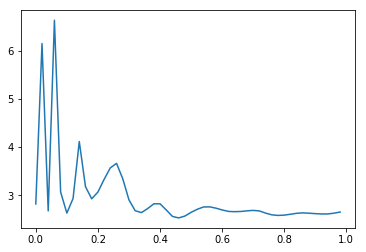

loss on validation set: 2.6521034240722656


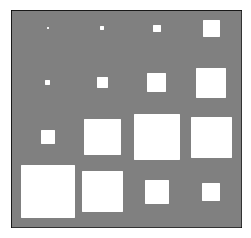

0it [00:00, ?it/s]

ccab


50it [00:03, 12.63it/s]


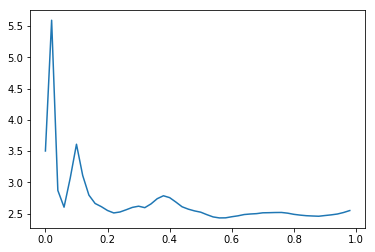

loss on validation set: 2.5477161407470703


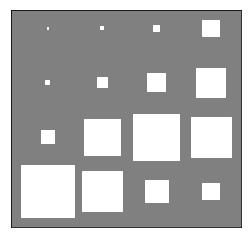

0it [00:00, ?it/s]

ccab


50it [00:04, 12.27it/s]


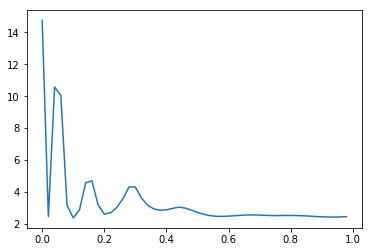

loss on validation set: 2.4516279697418213


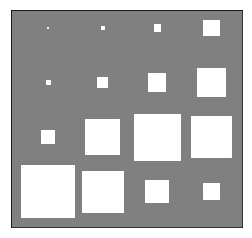

0it [00:00, ?it/s]

ccab


50it [00:04, 12.26it/s]


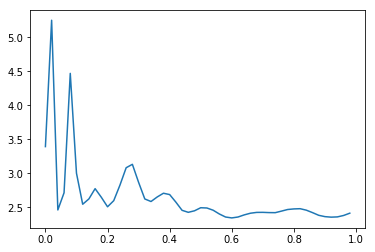

loss on validation set: 2.413322925567627


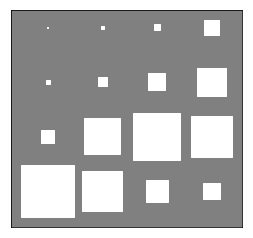

0it [00:00, ?it/s]

ccab


50it [00:04, 11.31it/s]


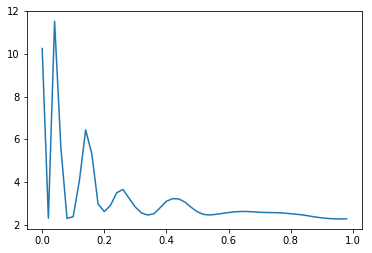

loss on validation set: 2.2767505645751953


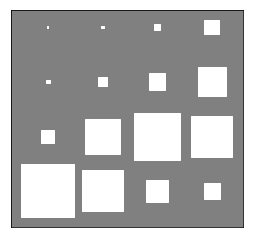

0it [00:00, ?it/s]

ccab


50it [00:04, 11.28it/s]


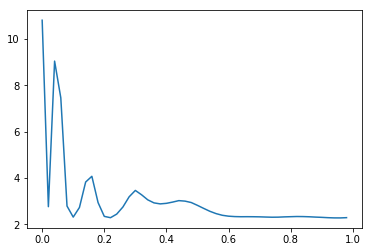

loss on validation set: 2.2920877933502197


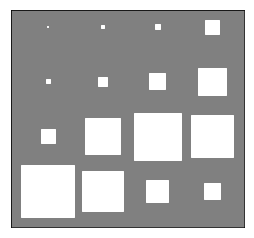

0it [00:00, ?it/s]

ccab


50it [00:04, 12.08it/s]


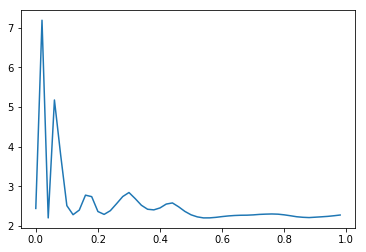

loss on validation set: 2.2773797512054443


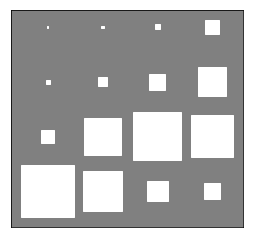

0it [00:00, ?it/s]

ccab


50it [00:04, 11.54it/s]


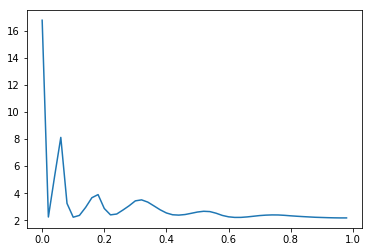

loss on validation set: 2.1753718852996826


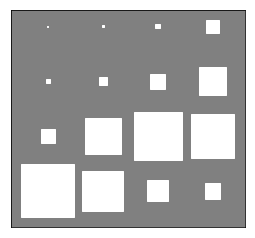

0it [00:00, ?it/s]

ccab


50it [00:04, 12.22it/s]


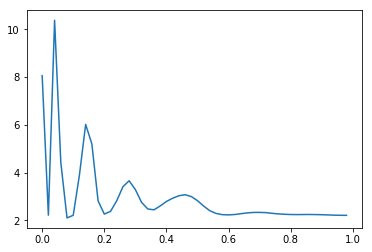

loss on validation set: 2.215057849884033


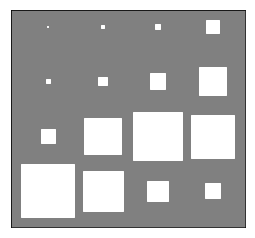

0it [00:00, ?it/s]

ccab


50it [00:03, 12.54it/s]


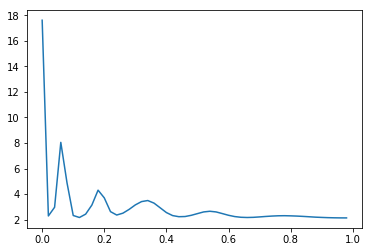

loss on validation set: 2.131168842315674


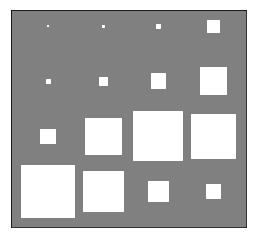

0it [00:00, ?it/s]

ccab


50it [00:04, 12.30it/s]


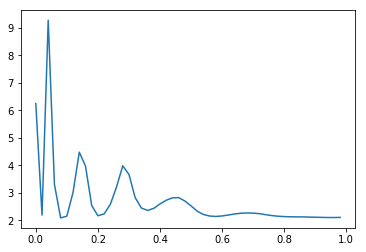

loss on validation set: 2.109132766723633


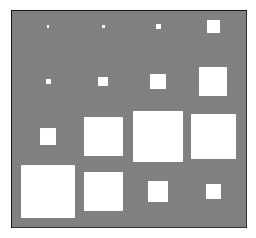

0it [00:00, ?it/s]

ccab


50it [00:04, 11.32it/s]


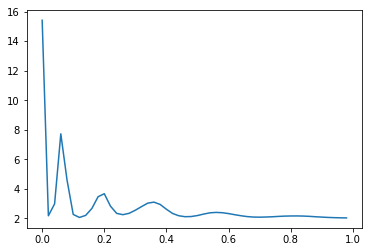

loss on validation set: 2.0345869064331055


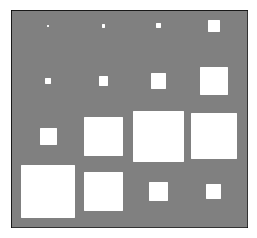

0it [00:00, ?it/s]

ccab


50it [00:04, 11.55it/s]


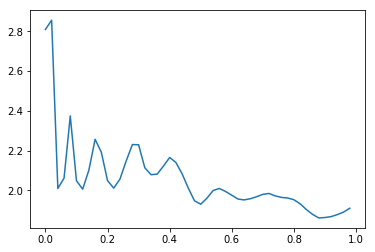

loss on validation set: 1.9100621938705444


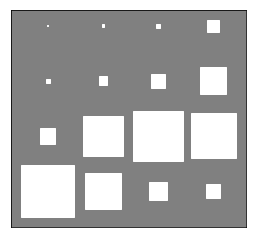

0it [00:00, ?it/s]

ccab


50it [00:04, 12.21it/s]


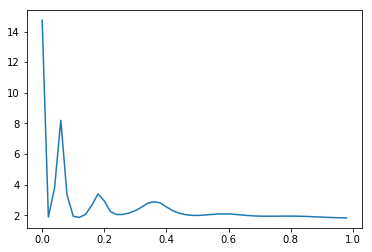

loss on validation set: 1.8328027725219727


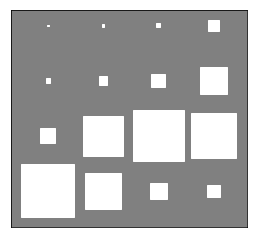

0it [00:00, ?it/s]

ccab


50it [00:04, 10.65it/s]


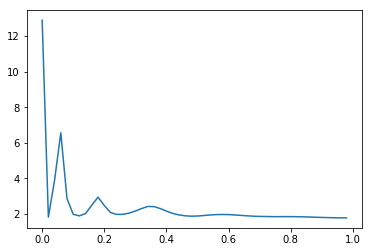

loss on validation set: 1.7674763202667236


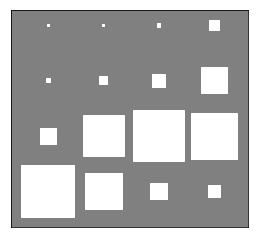

0it [00:00, ?it/s]

ccab


50it [00:06,  8.09it/s]


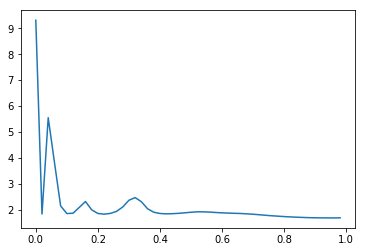

loss on validation set: 1.6825430393218994


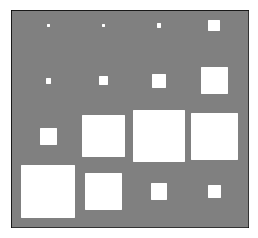

0it [00:00, ?it/s]

ccab


50it [00:08,  5.77it/s]


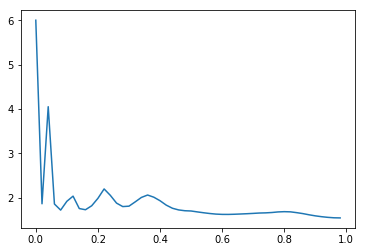

loss on validation set: 1.5403190851211548


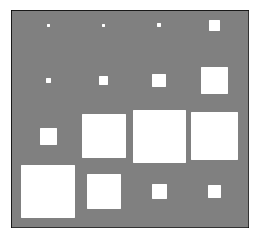

1it [00:00,  7.31it/s]

ccab


50it [00:07,  6.37it/s]


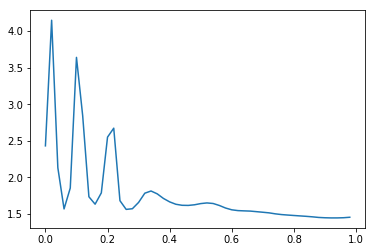

loss on validation set: 1.4570130109786987


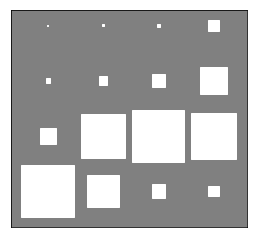

0it [00:00, ?it/s]

ccab


50it [00:08,  5.72it/s]


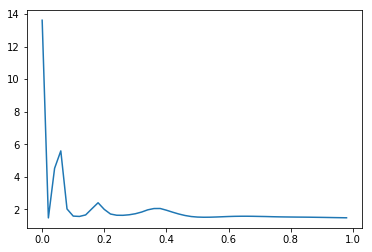

loss on validation set: 1.4760719537734985


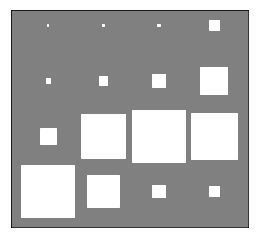

1it [00:00,  8.26it/s]

ccab


40it [00:04,  8.95it/s]


KeyboardInterrupt: 

In [12]:
while True:
    train(att, train_set, val_set, 1)
    print(att.generate_and_plot_attention('abc'))